In [4]:
import os
import gdown
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision.transforms as transforms

from skimage.metrics import structural_similarity as ssim_metric, peak_signal_noise_ratio as psnr_metric

In [ ]:
import zipfile
file_id = "1uJmDZw649XS-r-dYs9WD-OPwF_TIroVw"
output = "dataset.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet = False)

with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
  zip_ref.extractall("/content/dataset")

Downloading...
From (original): https://drive.google.com/uc?id=1uJmDZw649XS-r-dYs9WD-OPwF_TIroVw
From (redirected): https://drive.google.com/uc?id=1uJmDZw649XS-r-dYs9WD-OPwF_TIroVw&confirm=t&uuid=22729b50-4fdf-4c1c-b3c3-082e85210db3
To: /content/dataset.zip
100%|██████████| 533M/533M [00:06<00:00, 81.6MB/s]


In [6]:
class LensingDataset(Dataset):
  def __init__(self, root_dir, transform = None):
    super(LensingDataset, self).__init__()
    self.root_dir = root_dir
    self.hr_dir = os.path.join(root_dir, 'HR')
    self.lr_dir = os.path.join(root_dir, 'LR')
    self.lr_files = sorted(glob.glob(os.path.join(self.lr_dir, '*.npy')))
    self.hr_files = sorted(glob.glob(os.path.join(self.hr_dir, '*.npy')))
    self.transform = transform

  def __len__(self):
    return len(self.lr_files)

  def __getitem__(self, idx):
    lr_image = np.load(self.lr_files[idx])
    hr_image = np.load(self.hr_files[idx])

    lr_image = torch.from_numpy(lr_image).float()
    hr_image = torch.from_numpy(hr_image).float()

    if self.transform:
      lr_image = self.transform(lr_image)
      hr_image = self.transform(hr_image)


    lr_image = lr_image.repeat(3, 1, 1)
    hr_image = hr_image.repeat(3, 1, 1)
    return lr_image, hr_image

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, n_feats, kernel_size=3, res_scale=0.1):
        super(ResidualBlock, self).__init__()
        self.res_scale = res_scale
        self.block = nn.Sequential(
            nn.Conv2d(n_feats, n_feats, kernel_size, padding=kernel_size//2),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_feats, n_feats, kernel_size, padding=kernel_size//2)
        )

    def forward(self, x):
        res = self.block(x)
        return x + res * self.res_scale

In [11]:
class EDSR(nn.Module):
    def __init__(self, scale_factor=2, n_resblocks=16, n_feats=64, res_scale=0.1, n_colors=3):
        super(EDSR, self).__init__()
        self.head = nn.Conv2d(n_colors, n_feats, kernel_size=3, padding=1)

        self.body = nn.Sequential(
            *[ResidualBlock(n_feats, kernel_size=3, res_scale=res_scale) for _ in range(n_resblocks)]
        )
        self.body_conv = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)

        self.tail = nn.Sequential(
            nn.Conv2d(n_feats, n_feats * (scale_factor ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(scale_factor),
            nn.Conv2d(n_feats, n_colors, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.head(x)
        res = self.body(x)
        res = self.body_conv(res)
        x = x + res
        x = self.tail(x)
        return x

In [13]:
scale = 2
print("Initializing EDSR model...")
model = EDSR(scale_factor=scale, n_resblocks=8, n_feats=64, res_scale=0.1, n_colors=3)
model

Initializing EDSR model...


EDSR(
  (head): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (body): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [15]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [16]:
root_dir = "/content/dataset/Dataset"
train_dataset = LensingDataset(root_dir)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)

In [18]:
num_epochs = 10
print("Starting training on {} for {} epochs...".format(device, num_epochs))
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        optimizer.zero_grad()
        outputs = model(lr_imgs)
        loss = criterion(outputs, hr_imgs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * lr_imgs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print("Epoch [{}/{}], Loss: {:.6f}".format(epoch+1, num_epochs, epoch_loss))

Starting training on cuda for 10 epochs...


Epoch 1/10: 100%|██████████| 1250/1250 [01:18<00:00, 15.91it/s]


Epoch [1/10], Loss: 0.000168


Epoch 2/10: 100%|██████████| 1250/1250 [01:18<00:00, 15.86it/s]


Epoch [2/10], Loss: 0.000060


Epoch 3/10: 100%|██████████| 1250/1250 [01:20<00:00, 15.48it/s]


Epoch [3/10], Loss: 0.000060


Epoch 4/10: 100%|██████████| 1250/1250 [01:20<00:00, 15.49it/s]


Epoch [4/10], Loss: 0.000059


Epoch 5/10: 100%|██████████| 1250/1250 [01:20<00:00, 15.47it/s]


Epoch [5/10], Loss: 0.000059


Epoch 6/10: 100%|██████████| 1250/1250 [01:21<00:00, 15.40it/s]


Epoch [6/10], Loss: 0.000059


Epoch 7/10: 100%|██████████| 1250/1250 [01:20<00:00, 15.45it/s]


Epoch [7/10], Loss: 0.000059


Epoch 8/10: 100%|██████████| 1250/1250 [01:21<00:00, 15.42it/s]


Epoch [8/10], Loss: 0.000059


Epoch 9/10: 100%|██████████| 1250/1250 [01:21<00:00, 15.41it/s]


Epoch [9/10], Loss: 0.000059


Epoch 10/10: 100%|██████████| 1250/1250 [01:21<00:00, 15.43it/s]

Epoch [10/10], Loss: 0.000059


In [19]:
def evaluate(model, dataloader, device):
    model.eval()
    mse_total, ssim_total, psnr_total = 0.0, 0.0, 0.0
    count = 0
    with torch.no_grad():
        for lr_imgs, hr_imgs in tqdm(dataloader, desc="Evaluating"):
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)

            outputs = model(lr_imgs)
            outputs_np = outputs.cpu().numpy()
            hr_imgs_np = hr_imgs.cpu().numpy()

            for i in range(outputs_np.shape[0]):
                # Convert to grayscale by taking the first channel.
                sr = outputs_np[i, 0, :, :]
                hr = hr_imgs_np[i, 0, :, :]
                mse_val = np.mean((sr - hr) ** 2)
                ssim_val = ssim_metric(sr, hr, data_range=hr.max()-hr.min())
                psnr_val = psnr_metric(hr, sr, data_range=hr.max()-hr.min())

                mse_total += mse_val
                ssim_total += ssim_val
                psnr_total += psnr_val
                count += 1

    return mse_total/count, ssim_total/count, psnr_total/count

In [20]:
mse_val, ssim_val, psnr_val = evaluate(model, train_loader, device)
print("Evaluation Metrics:")
print("MSE: {:.6f}".format(mse_val))
print("SSIM: {:.6f}".format(ssim_val))
print("PSNR: {:.6f}".format(psnr_val))

Evaluating: 100%|██████████| 1250/1250 [00:48<00:00, 25.52it/s]

Evaluation Metrics:
MSE: 0.000059
SSIM: 0.977661
PSNR: 42.343273


In [21]:
def show_generated_images(model, dataloader, device, num_images=5):
    """
    Displays a few super-resolved images alongside the original LR and HR images.
    """
    model.eval()
    lr_imgs, hr_imgs = next(iter(dataloader))
    lr_imgs = lr_imgs.to(device)
    hr_imgs = hr_imgs.to(device)

    with torch.no_grad():
        sr_imgs = model(lr_imgs)

    lr_imgs = lr_imgs.cpu().numpy()
    sr_imgs = sr_imgs.cpu().numpy()
    hr_imgs = hr_imgs.cpu().numpy()

    num_images = min(num_images, lr_imgs.shape[0])
    fig, axes = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))

    if num_images == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(num_images):
        lr_img = lr_imgs[i, 0, :, :]
        sr_img = sr_imgs[i, 0, :, :]
        hr_img = hr_imgs[i, 0, :, :]

        axes[i, 0].imshow(lr_img, cmap='gray')
        axes[i, 0].set_title("Low Resolution")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(sr_img, cmap='gray')
        axes[i, 1].set_title("Super Resolved")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(hr_img, cmap='gray')
        axes[i, 2].set_title("High Resolution")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

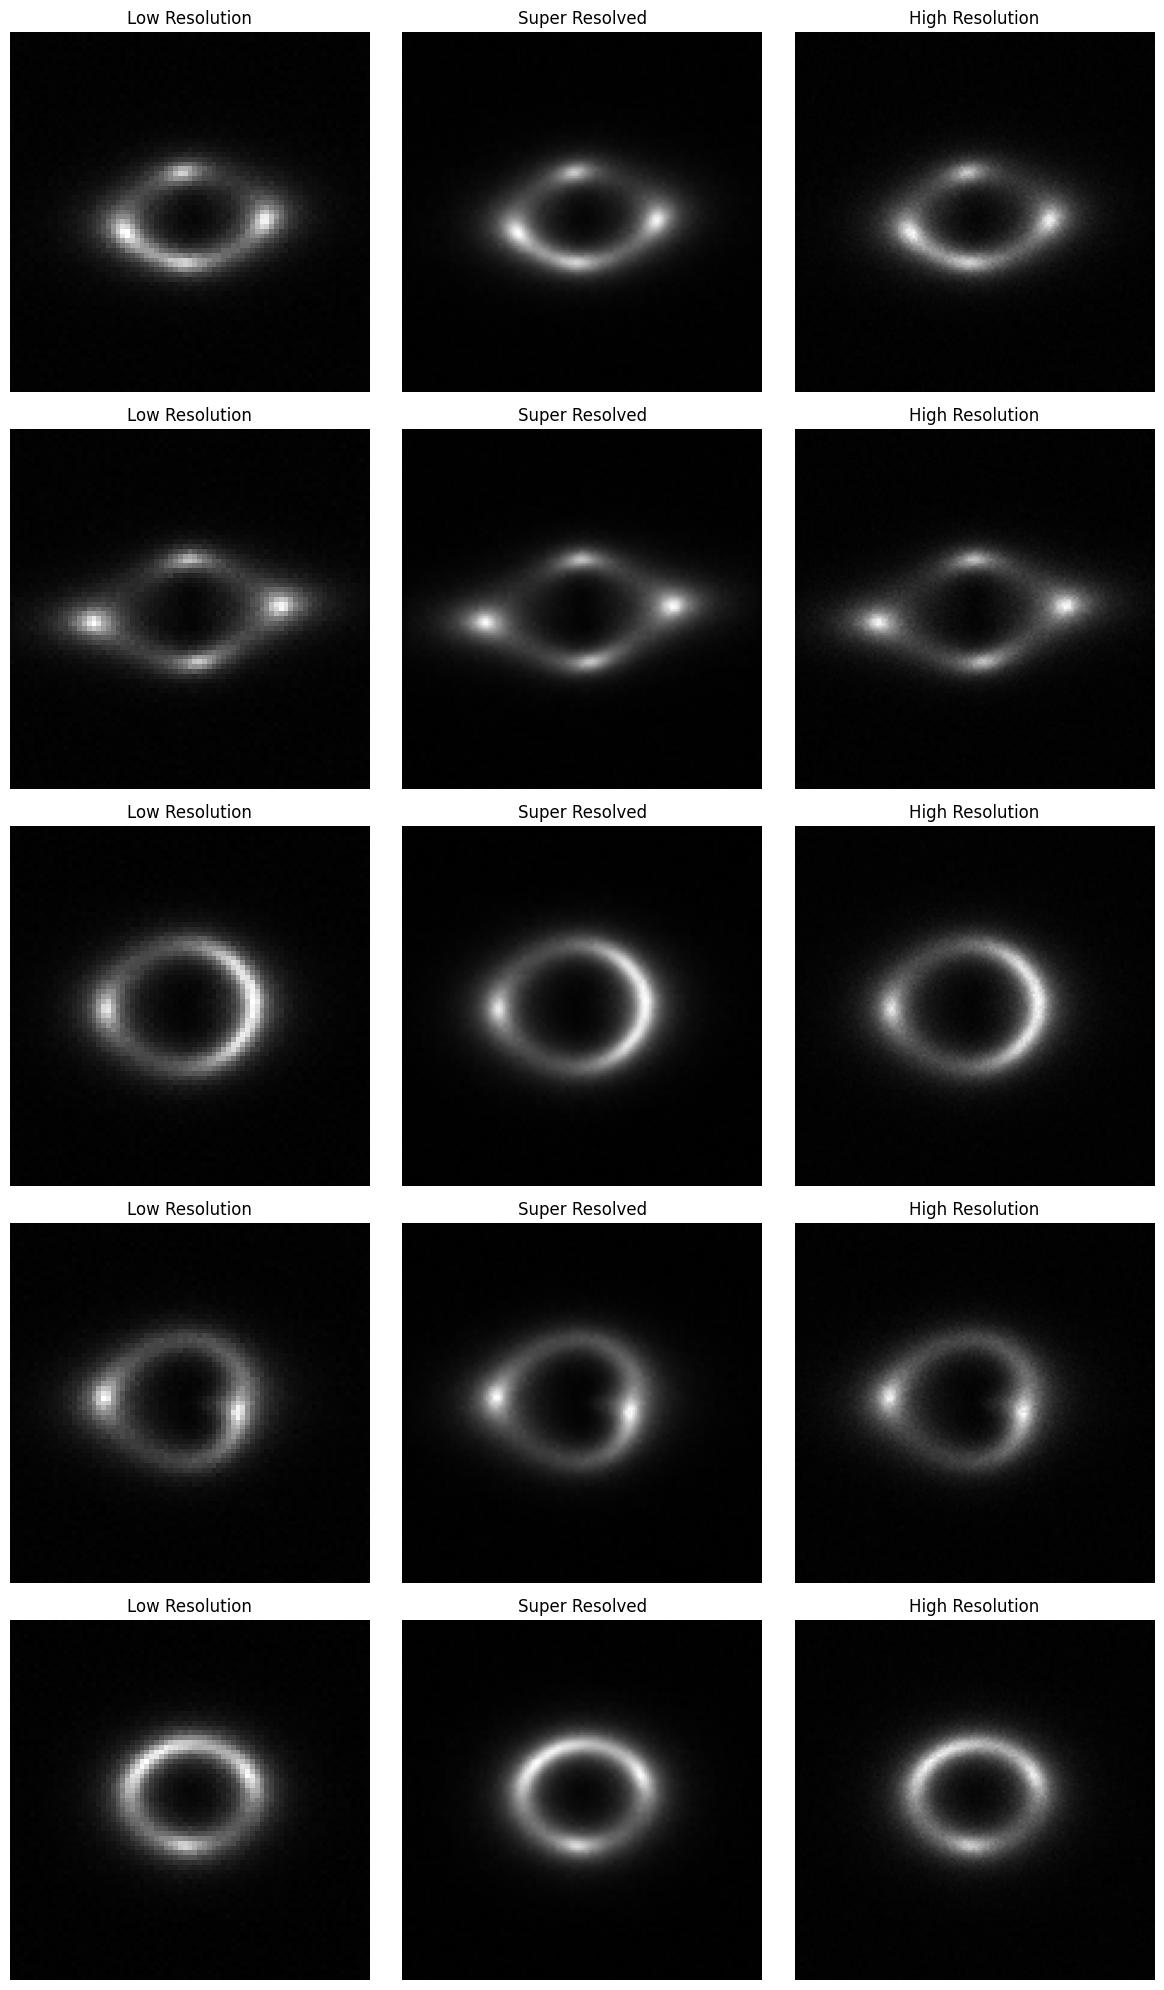

In [22]:
show_generated_images(model, train_loader, device, num_images=5)

In [23]:
torch.save(model.state_dict(), 'edsr_strong_lensing_finetuned.pth')
print("Model saved.")

Model saved.


In [24]:
file_id = "1plYfM-jFJT7TbTMVssuCCFvLzGdxMQ4h"
output = "datasetB.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet = False)

with zipfile.ZipFile("datasetB.zip", "r") as zip_ref:
  zip_ref.extractall("/content/datasetB")

Downloading...
From: https://drive.google.com/uc?id=1plYfM-jFJT7TbTMVssuCCFvLzGdxMQ4h
To: /content/datasetB.zip
100%|██████████| 21.6M/21.6M [00:00<00:00, 67.1MB/s]


In [25]:
path = "/content/datasetB/Dataset/HR/HR_1.npy"
image = np.load(path)
image.shape

(1, 128, 128)

In [26]:
path = "/content/datasetB/Dataset/LR/LR_1.npy"
image = np.load(path)
image.shape

(1, 64, 64)

In [37]:
class RealLensingDataset(Dataset):
  def __init__(self, root_dir, transform = None):
    super(RealLensingDataset, self).__init__()
    self.lr_dir = os.path.join(root_dir, 'LR')
    self.hr_dir = os.path.join(root_dir, 'HR')
    self.lr_files = sorted(glob.glob(os.path.join(self.lr_dir, '*.npy')))
    self.hr_files = sorted(glob.glob(os.path.join(self.hr_dir, '*.npy')))
    self.transform = transform

  def __len__(self):
    return len(self.lr_files)

  def __getitem__(self, idx):
    lr_img = np.load(self.lr_files[idx])
    hr_img = np.load(self.hr_files[idx])

    lr_img = torch.from_numpy(lr_img).float()
    hr_img = torch.from_numpy(hr_img).float()

    lr_img = lr_img.repeat(3, 1, 1)
    hr_img = hr_img.repeat(3, 1, 1)

    if self.transform:
      lr_img = self.transform(lr_img)
      hr_img = self.transform(hr_img)

    return lr_img, hr_img

In [38]:
scale = 2
print("Initializing EDSR model for fine-tuning...")
model = EDSR(scale_factor=scale, n_resblocks=8, n_feats=64, res_scale=0.1, n_colors=3)

Initializing EDSR model for fine-tuning...


In [39]:
pretrained_weights = 'edsr_strong_lensing_finetuned.pth'
model.load_state_dict(torch.load(pretrained_weights, map_location='cpu'))
print("Pre-trained weights loaded.")

Pre-trained weights loaded.


<ipython-input-39-95e6a2d481d0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_weights, map_location='cpu'))


In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [41]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [45]:
import random
class RandomFlipRotate(object):
    """Apply random horizontal/vertical flips and random 90° rotations."""
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image):
        if random.random() < self.p:
            image = torch.flip(image, dims=[2])  # horizontal flip
        if random.random() < self.p:
            image = torch.flip(image, dims=[1])  # vertical flip
        rotations = random.randint(0, 3)
        image = torch.rot90(image, k=rotations, dims=[1, 2])
        return image

In [43]:
root_dir = "/content/datasetB/Dataset"
data_transform = transforms.Compose([RandomFlipRotate(p=0.5)])
real_dataset = RealLensingDataset(root_dir, transform=data_transform)
real_loader = DataLoader(real_dataset, batch_size=4, shuffle=True, num_workers=2)

In [46]:
num_finetune_epochs = 10
print("Starting fine-tuning on real data for {} epochs...".format(num_finetune_epochs))
for epoch in range(num_finetune_epochs):
    model.train()
    running_loss = 0.0
    for lr_imgs, hr_imgs in tqdm(real_loader, desc=f"Fine-tune Epoch {epoch+1}/{num_finetune_epochs}"):
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        optimizer.zero_grad()
        outputs = model(lr_imgs)
        loss = criterion(outputs, hr_imgs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * lr_imgs.size(0)
    epoch_loss = running_loss / len(real_dataset)
    print("Epoch [{}/{}], Fine-tuning Loss: {:.6f}".format(epoch+1, num_finetune_epochs, epoch_loss))

Starting fine-tuning on real data for 10 epochs...


Fine-tune Epoch 1/10:   0%|          | 0/75 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b8a4cd81b20><function _MultiProcessingDataLoaderIter.__del__ at 0x7b8a4cd81b20>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
    
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive(): 
     ^   ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid

Epoch [1/10], Fine-tuning Loss: 0.005273


Fine-tune Epoch 2/10: 100%|██████████| 75/75 [00:01<00:00, 41.05it/s]


Epoch [2/10], Fine-tuning Loss: 0.002429


Fine-tune Epoch 3/10: 100%|██████████| 75/75 [00:02<00:00, 35.98it/s]


Epoch [3/10], Fine-tuning Loss: 0.002132


Fine-tune Epoch 4/10: 100%|██████████| 75/75 [00:01<00:00, 39.50it/s]


Epoch [4/10], Fine-tuning Loss: 0.002031


Fine-tune Epoch 5/10: 100%|██████████| 75/75 [00:01<00:00, 41.31it/s]


Epoch [5/10], Fine-tuning Loss: 0.002033


Fine-tune Epoch 6/10: 100%|██████████| 75/75 [00:02<00:00, 36.07it/s]


Epoch [6/10], Fine-tuning Loss: 0.002003


Fine-tune Epoch 7/10: 100%|██████████| 75/75 [00:01<00:00, 38.54it/s]


Epoch [7/10], Fine-tuning Loss: 0.001978


Fine-tune Epoch 8/10: 100%|██████████| 75/75 [00:01<00:00, 40.85it/s]


Epoch [8/10], Fine-tuning Loss: 0.001985


Fine-tune Epoch 9/10: 100%|██████████| 75/75 [00:01<00:00, 41.25it/s]


Epoch [9/10], Fine-tuning Loss: 0.001930


Fine-tune Epoch 10/10: 100%|██████████| 75/75 [00:01<00:00, 40.60it/s]

Epoch [10/10], Fine-tuning Loss: 0.001934


In [47]:
def evaluate(model, dataloader, device):
    model.eval()
    mse_total, ssim_total, psnr_total = 0.0, 0.0, 0.0
    count = 0
    with torch.no_grad():
        for lr_imgs, hr_imgs in tqdm(dataloader, desc="Evaluating"):
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            outputs = model(lr_imgs)
            outputs_np = outputs.cpu().numpy()
            hr_imgs_np = hr_imgs.cpu().numpy()

            for i in range(outputs_np.shape[0]):
                # Convert to grayscale by taking the first channel.
                sr = outputs_np[i, 0, :, :]
                hr = hr_imgs_np[i, 0, :, :]
                mse_val = np.mean((sr - hr)**2)
                ssim_val = ssim_metric(sr, hr, data_range=hr.max()-hr.min())
                psnr_val = psnr_metric(hr, sr, data_range=hr.max()-hr.min())

                mse_total += mse_val
                ssim_total += ssim_val
                psnr_total += psnr_val
                count += 1
    return mse_total/count, ssim_total/count, psnr_total/count

In [48]:
mse_val, ssim_val, psnr_val = evaluate(model, real_loader, device)
print("Evaluation Metrics on Real Data:")
print("MSE: {:.6f}".format(mse_val))
print("SSIM: {:.6f}".format(ssim_val))
print("PSNR: {:.6f}".format(psnr_val))

Evaluating: 100%|██████████| 75/75 [00:01<00:00, 55.58it/s]

Evaluation Metrics on Real Data:
MSE: 0.001903
SSIM: 0.757113
PSNR: 29.645286


In [49]:
def show_generated_images(model, dataloader, device, num_images=5):
    """
    Displays LR input, SR output, and HR ground truth images side by side.
    """
    model.eval()
    lr_imgs, hr_imgs = next(iter(dataloader))
    lr_imgs = lr_imgs.to(device)
    hr_imgs = hr_imgs.to(device)

    with torch.no_grad():
        sr_imgs = model(lr_imgs)

    lr_imgs = lr_imgs.cpu().numpy()
    sr_imgs = sr_imgs.cpu().numpy()
    hr_imgs = hr_imgs.cpu().numpy()

    num_images = min(num_images, lr_imgs.shape[0])
    fig, axes = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))
    if num_images == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(num_images):
        lr_img = lr_imgs[i, 0, :, :]
        sr_img = sr_imgs[i, 0, :, :]
        hr_img = hr_imgs[i, 0, :, :]

        axes[i, 0].imshow(lr_img, cmap='gray')
        axes[i, 0].set_title("Low Resolution")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(sr_img, cmap='gray')
        axes[i, 1].set_title("Super Resolved")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(hr_img, cmap='gray')
        axes[i, 2].set_title("High Resolution")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

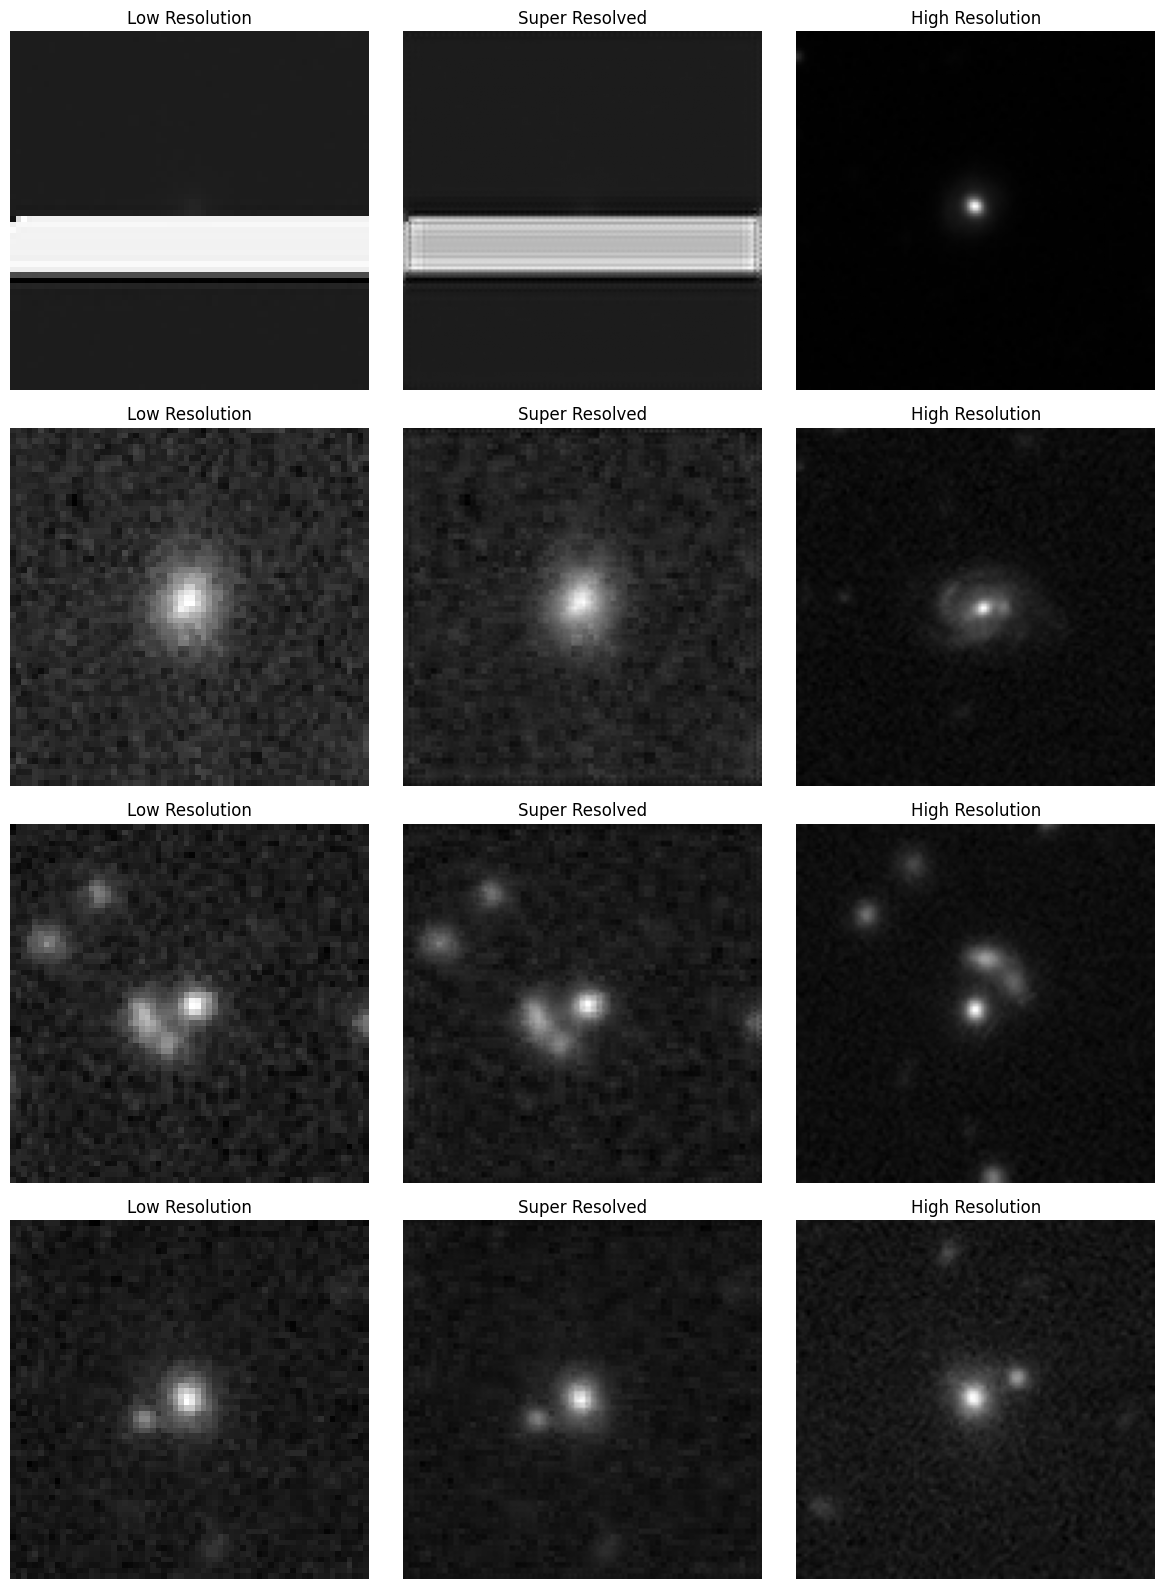

In [50]:
show_generated_images(model, real_loader, device, num_images=5)